In [1]:
import import_ipynb

from statsmodels.distributions.empirical_distribution import ECDF
import numpy as np
import users

%matplotlib inline
from matplotlib.ticker import MaxNLocator
import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.rcParams["figure.figsize"] = (20, 6)

In [2]:
ad_directories, user_directories, num_categories = users.get_ad_and_user_directories(["ADS16_Benchmark_part1", "ADS16_Benchmark_part2"])

In [3]:
b5_list = []
im_neg_arrays_list = []
im_pos_arrays_list = []
gender_age_income_list = []
mean_rt_per_cat_list = []

last_user_id = user_directories[-1].replace("/", "\\").split("\\")[-1]
for (
    user_id,
    b5,
    im_neg_arrays,
    im_pos_arrays,
    gender_age_income,
    mean_rt_per_cat,
    _
) in users.user_data_iterator(user_directories):
    b5_list.append(b5)
    im_neg_arrays_list.append(im_neg_arrays)
    im_pos_arrays_list.append(im_pos_arrays)
    gender_age_income_list.append(gender_age_income)
    mean_rt_per_cat_list.append(mean_rt_per_cat)
    print(f"Loaded user {user_id}/{last_user_id}", end="\r")


b5_list = np.array(b5_list)
im_neg_arrays_list = np.array(im_neg_arrays_list)
im_pos_arrays_list = np.array(im_pos_arrays_list)
gender_age_income_list = np.array(gender_age_income_list)
mean_rt_per_cat_list = np.array(mean_rt_per_cat_list)


Failed to load user U0011 (not enough images): 1 total failure
Failed to load user U0024 (bad images): 2 total failures
Failed to load user U0039 (bad images): 3 total failures
Failed to load user U0042 (bad images): 4 total failures


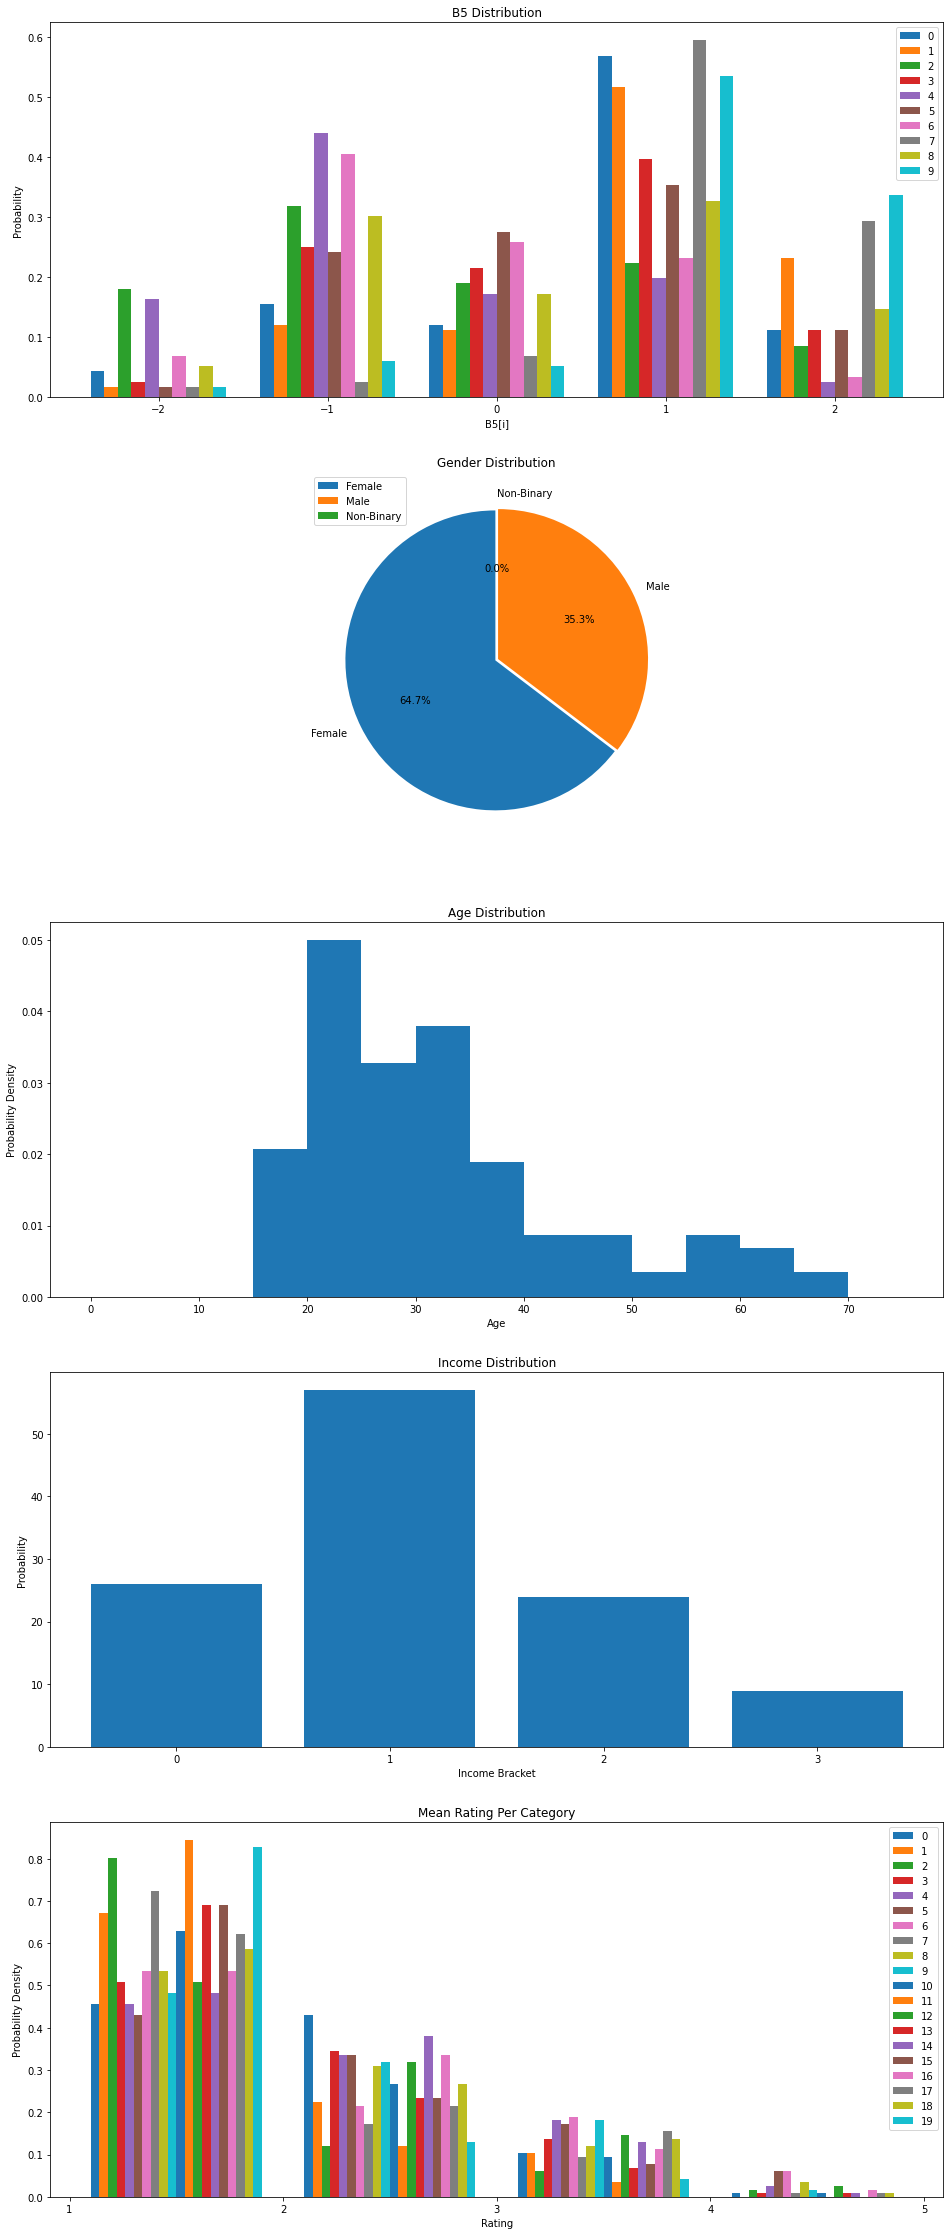

In [43]:
num_plots = 1 + 3 + 1
fig, axs = plt.subplots(num_plots, figsize=(16, num_plots*8))

i = 0
axs[i].set_title("B5 Distribution")
axs[i].set_xlabel("B5[i]")
axs[i].set_ylabel("Probability")
axs[i].xaxis.set_major_locator(MaxNLocator(integer=True))
axs[i].hist(b5_list, bins=np.arange(-3,3)+0.5, density=True, label=np.arange(b5_list.shape[1]))
axs[i].legend()
i += 1

axs[i].set_title("Gender Distribution")
gender_sizes = [np.sum(gender_age_income_list[:,0] == 1), np.sum(gender_age_income_list[:,0] == 0)]
gender_sizes.append(gender_age_income_list.shape[0]-sum(gender_sizes))
axs[i].pie(gender_sizes, labels=["Female", "Male", "Non-Binary"], autopct='%1.1f%%', startangle=90, explode=[0.01]*len(gender_sizes))
axs[i].legend()
i += 1

axs[i].set_title("Age Distribution")
axs[i].set_xlabel("Age")
axs[i].set_ylabel("Probability Density")
axs[i].xaxis.set_major_locator(MaxNLocator(integer=True))
axs[i].hist(gender_age_income_list[:,1], bins=np.arange(0, np.max(gender_age_income_list[:,1])+10, 5), density=True)
i += 1


axs[i].set_title("Income Distribution")
axs[i].set_xlabel("Income Bracket")
axs[i].set_ylabel("Probability")
axs[i].xaxis.set_major_locator(MaxNLocator(integer=True))
axs[i].bar(*np.unique(gender_age_income_list[:,2], return_counts=True))
i += 1

axs[i].set_title("Mean Rating Per Category")
axs[i].set_xlabel("Rating")
axs[i].set_ylabel("Probability Density")
axs[i].xaxis.set_major_locator(MaxNLocator(integer=True))
axs[i].hist(mean_rt_per_cat_list, bins=np.arange(1,6), density=True, label=np.arange(mean_rt_per_cat_list.shape[1]))
axs[i].legend()
i += 1


In [5]:
class Empirical:
    def __init__(self, values):
        self.empty = len(values) == 0
        if not self.empty:
            self.unique, counts = np.unique(values, return_counts=True)
            self.probabilities = counts/len(values)
            self.cutoffs = np.cumsum(self.probabilities)
            error = 1-self.cutoffs[-1]
            assert np.isclose(error, 0)
            distributed_error = np.arange(1,len(self.unique)+1)*error/len(self.unique)
            self.probabilities += error/len(self.unique)
            self.cutoffs += distributed_error
            assert self.cutoffs[-1] == 1


In [6]:
class DiscreteEmpirical(Empirical):
    def sample(self, n):
        if self.empty:
            return np.empty(n) + np.nan
        r = np.random.uniform(size=n)
        sample = np.copy(r)
        last = 0
        for i, u in enumerate(self.unique):
            sample[np.logical_and(last <= r, r < self.cutoffs[i])] = u
            last = self.cutoffs[i]
        return sample
        

In [7]:
def remap(x, a, b, u, v):
    t = (x-a)/(b-a)
    return t * (v-u) + u

# Uses linear interpolation between datapoints
class ContinuousEmpirical(Empirical):
    def __init__(self, values):
        super().__init__(np.sort(values))
        if not self.empty:
            self.min = np.min(self.unique)

    def sample(self, n):
        if self.empty:
            return np.empty(n) + np.nan
        r = np.random.uniform(size=n)
        sample = np.copy(r)
        last_p = 0
        last_u = 0
        for i, u in enumerate(self.unique):
            sample = np.where(np.logical_and(last_p <= r, r < self.cutoffs[i]), remap(r, last_p, self.cutoffs[i], u, last_u), sample)
            last_p = self.cutoffs[i]
            last_u = u
        return sample + self.min
        

In [60]:
b5_dists = []
for v in b5_list.T:
    b5_dists.append(DiscreteEmpirical(v))

binary_gender = np.logical_or(gender_age_income_list[:,0]==0,gender_age_income_list[:,0]==1)
is_binary_gender_dist = DiscreteEmpirical(binary_gender)
binary_gender_dist = DiscreteEmpirical(gender_age_income_list[:,0][binary_gender])
nonbinary_gender_dist = ContinuousEmpirical(gender_age_income_list[:,0][~binary_gender])
age_dist = DiscreteEmpirical(gender_age_income_list[:,1])
income_dist = DiscreteEmpirical(gender_age_income_list[:,2])

mean_rt_dists = []
for v in mean_rt_per_cat_list.T:
    mean_rt_dists.append(ContinuousEmpirical(v))

imgs_per_user = im_neg_arrays_list.shape[1]
assert imgs_per_user == im_pos_arrays_list.shape[1]

all_im_neg_arrays = im_neg_arrays_list.reshape((im_neg_arrays_list.shape[0]*imgs_per_user,*im_neg_arrays_list.shape[2:]))
all_im_pos_arrays = im_pos_arrays_list.reshape((im_pos_arrays_list.shape[0]*imgs_per_user,*im_pos_arrays_list.shape[2:]))

def generate_simulated_users(n):
    b5 = np.zeros((n,len(b5_dists)))
    for i, dist in enumerate(b5_dists):
        b5[:,i] = dist.sample(n)
    
    gender_age_income = np.zeros((n,3))

    is_binary_gender = is_binary_gender_dist.sample(n)
    binary_gender_sample = binary_gender_dist.sample(n)
    nonbinary_gender_sample = nonbinary_gender_dist.sample(n)

    gender_age_income[:,0] = np.where(is_binary_gender, binary_gender_sample, nonbinary_gender_sample)
    gender_age_income[:,1] = age_dist.sample(n)
    gender_age_income[:,2] = income_dist.sample(n)
    
    mean_rt_per_cat = np.zeros((n, num_categories))
    for i, dist in enumerate(mean_rt_dists):
        mean_rt_per_cat[:,i] = dist.sample(n)
    
    neg_idxs = np.random.randint(len(all_im_neg_arrays), size=(n,imgs_per_user))
    im_neg_arrays = all_im_neg_arrays[neg_idxs]

    pos_idxs = np.random.randint(len(all_im_pos_arrays), size=(n,imgs_per_user))
    im_pos_arrays = all_im_pos_arrays[pos_idxs]

    return b5, im_neg_arrays, im_pos_arrays, gender_age_income, mean_rt_per_cat


In [9]:
*ads, num_ads, _, _ = users.load_ads(ad_directories, num_categories)

Loaded ad category 20/20
Embedding text...
Done


In [61]:
user_model = users.create_model()
user_model.load_weights("users-checkpoints/model-000008-2.3838.hdf5")

In [62]:
def predict_ratings(users_data, ads_data, batch_size=256, verbose=False):
    b5, im_neg_arrays, im_pos_arrays, gender_age_income, mean_rt_per_cat = users_data
    ad_categories, ad_imgs, ad_char_embeddings = ads_data

    assert len(b5) == len(ad_categories)

    x0 = np.concatenate((b5, gender_age_income, mean_rt_per_cat, ad_categories), axis=1)
    x1 = np.concatenate((im_pos_arrays, im_neg_arrays, ad_imgs[:, np.newaxis, :, :, :]), axis=1)
    x2 = ad_char_embeddings

    ratings = np.zeros(0)

    for i in range(0, b5.shape[0], batch_size):
        y = user_model((x0[i:i+batch_size], x1[i:i+batch_size], x2[i:i+batch_size]))
        r = users.one_hots_to_ratings(y).numpy()
        ratings = np.concatenate([ratings, r])
        if verbose:
            print(f"{min(i+batch_size, b5.shape[0])}/{b5.shape[0]} ({100*(min(i+batch_size, b5.shape[0])/b5.shape[0]):.2f}%)", end="                  \r")
    if verbose:
        print("", end="")

    return ratings


In [63]:
def predict_ratings_cartesian_product(users_data, ads_data, batch_size=256):
    num_ads = ads_data[0].shape[0]
    num_users = users_data[0].shape[0]
    users_data = tuple(np.swapaxes(np.broadcast_to(x, (num_ads, *x.shape)), 0, 1).reshape((num_users*num_ads, *x.shape[1:])) for x in users_data)
    ads_data = tuple(np.broadcast_to(x, (num_users, *x.shape)).reshape((num_users*num_ads, *x.shape[1:])) for x in ads_data)
    ad_categories = ads_data[0]
    return predict_ratings(users_data, ads_data, batch_size=batch_size, verbose=True), ad_categories

In [64]:
n = 5
simulated_users = generate_simulated_users(n)
ratings, categories = predict_ratings_cartesian_product(simulated_users, ads)

In [68]:
r = np.broadcast_to(ratings, (num_categories, *ratings.shape)).T
r = r.reshape((n, num_ads, *r.shape[1:]))
simulated_mean_rt_per_cat = np.average(r, axis=1, weights=categories.reshape(r.shape))


mae = np.average(np.abs(simulated_mean_rt_per_cat - simulated_users[4]))
print(f"For {n} simulated users, mean absolute difference in mean rating per category:")
print(mae)

For 5 simulated users, mean absolute difference in mean rating per category:
0.7396851453675655
